In [2]:
# Breast Cancer classifier Machine Learning Code
# Author - Paul Stone
# Institution - Wright State University
# Created 29/11/2018

# import libraries etc. 

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import warnings

In [3]:
#  set up variables 

rfe_selections = []
rfecv_selections = []
chi2_selections = []
all_selections = []
rfe_accs = [0]
rfecv_accs = [0]
chi2_accs = [0]
all_accs = [0]
Mod_count = []
Acc_count = []

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# *********************************************read data from .csv******************************************************


######################### note that this code has extra content from the class, primarily to nofify if there are data removed etc. 



BCdata = np.genfromtxt('BCdata.csv', delimiter=',', dtype=str, missing_values="no_data")                                # read in .csv and assign "No_data" to missing values

print("imported data has", BCdata.shape[0], "rows and", BCdata.shape[1], "columns")                                     # MSG confirm shape of input data

BCdata_missing = BCdata[np.any(BCdata == "no_data", axis=1)]                                                            #remove missing values
BCdata_c = BCdata[~np.any(BCdata == "no_data", axis=1)]

if BCdata_missing.shape[0] == 0:
    print("there were no rows removed due to missing or null data in the input file")                                   # MSG confirm if any data was removed
else:
    print(BCdata_missing.shape[0], "row(s) removed due to missing data")

BCdata_c = BCdata_c[(BCdata_c[:, 0] != "no-recurrence-events") | (BCdata_c[:, 0] != "recurrence-events")]               #Remove rows wtih data that is not a positive match for known data

BCdata_c = BCdata_c[(BCdata_c[:, 1] == "70-79") | (BCdata_c[:, 1] == "60-69") | (BCdata_c[:, 1] == "50-59")
    | (BCdata_c[:, 1] == "40-49") | (BCdata_c[:, 1] == "30-39") | (BCdata_c[:, 1] == "20-29")]

BCdata_c = BCdata_c[(BCdata_c[:, 2] == "premeno") | (BCdata_c[:, 2] == "ge40") | (BCdata_c[:, 2] == "lt40")]

BCdata_c = BCdata_c[(BCdata_c[:, 8] == "right_low") | (BCdata_c[:, 8] == "right_up") | (BCdata_c[:, 8] == "left_low")
    | (BCdata_c[:, 8] == "left_up") | (BCdata_c[:, 8] == "central")]

BCdata_c = BCdata_c[(BCdata_c[:, 5] == "no") | (BCdata_c[:, 5] == "yes")]

if BCdata_missing.shape[0]==BCdata_c.shape[0]:                                                                          # MSG confirm second stage of data removal
    print("there were no inconsistent values present in the input file")
else:
    print(((BCdata.shape[0]-BCdata_missing.shape[0])-BCdata_c.shape[0]), "row(s) removed due to inconsistent data")

print("in total", (BCdata.shape[0]-BCdata_c.shape[0]), "row(s) were removed from the data")                             # MSG total lines removed and %of data removed
Pct_rem = round(100-((100/BCdata.shape[0])*BCdata_c.shape[0]),2)
print(Pct_rem, "% of the data was removed from the Machine Learning dataset")
print("Data set for use in machine learning algorithm has", BCdata_c.shape[0], "rows and", BCdata_c.shape[1], "columns")

imported data has 286 rows and 10 columns
there were no rows removed due to missing or null data in the input file
9 row(s) removed due to inconsistent data
in total 9 row(s) were removed from the data
3.15 % of the data was removed from the Machine Learning dataset
Data set for use in machine learning algorithm has 277 rows and 10 columns


In [5]:
# ********************split data into test and training sets 75 for training, 25 for test*******************************

data_rows = BCdata_c.shape[0]                                                                                           # determine rows in data and test/train split
training_rows = round(data_rows*0.75)  # this is where the 75/25 split is identified
test_rows = data_rows-training_rows

np.random.seed(1234)                                                                                                    # seed RNG
np.random.shuffle(BCdata_c)                                                                                             # randomize order of dataset to ensure no bias in Training/test sets
training, test = BCdata_c[:training_rows, :], BCdata_c[training_rows:, :]

print("Training data has", training.shape[0], "rows and", training.shape[1], "columns")                                 # MSG confirm test/training dataset shape
print("test", test.shape[0], "rows and", test.shape[1], "columns")

data_headers = ["RecEvs", "Age", "MenoP", "TumorSz", "LnodeInv", "NodeCap", "Malignancy", "BreastSide", "BreastLoc",    # add headers to train and test data
                "Radiation"]

test_h = np.insert(test,0,data_headers,0)
training_h = np.insert(training,0,data_headers,0)

new_col_train = np.zeros((training_rows+1,1))                                                                           # add dummy column to allow indexing overwrite
new_col_test = np.zeros((test_rows+1,1))
training_hi = np.append(new_col_train, training_h, 1)
test_hi = np.append(new_col_test, test_h, 1)

train_data_p = pd.DataFrame(data=training_hi[1:,1:], index=(np.array(range(1,training_rows+1))), columns=training_hi    # convert Numpy Arrays to Pandas dataframes to enable dummy data production
                            [0, 1:])
test_data_p = pd.DataFrame(data=test_hi[1:,1:], index=(np.array(range(1,test_rows+1))), columns=test_hi[0,1:])

Training data has 208 rows and 10 columns
test 69 rows and 10 columns


In [6]:
# *************************************create dummy variables to enable logistic Regression*****************************

train_data_p['RecEvs'] = train_data_p['RecEvs'].map({'recurrence-events': 1, 'no-recurrence-events': 0})                # Convert nominal recurrence to binary
train_dummy_RecEvs = train_data_p["RecEvs"]

train_data_p['Age'] = train_data_p['Age'].map({'20-29': 20, '30-39': 30, '40-49': 40, '50-59': 50, '60-69': 60,         # convert nominal age to integer for logistic regression
                                               '70-79': 70})
train_dummy_age = train_data_p["Age"]                                                                                   # write new age dataframe

train_dummy_MenoP = pd.get_dummies(train_data_p["MenoP"])

train_data_p['TumorSz'] = train_data_p['TumorSz'].map({'0-4': 2, '5-9': 7, '10-14': 12, '15-19': 17, '20-24': 22,       # convert nominal tumor size to continous integer
                                                       '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42, '45-49': 47,
                                                       '50-54': 52})
train_dummy_tumor = train_data_p["TumorSz"]

train_data_p['LnodeInv'] = train_data_p['LnodeInv'].map({'0-2': 1, '3-5': 4, '6-8': 7, '9-11':8, '12-14':13, '15-17': 16# convert nominal node inv variable to continous integer
                                                        , '18-20': 19, '21-23': 22, '24-26': 25})
train_dummy_Lnode = train_data_p["LnodeInv"]

train_data_p['NodeCap'] = train_data_p['NodeCap'].map({'yes': 1, 'no': 0})                                              # convert nominal age to integer for logistic regression
train_dummy_ncap = train_data_p["NodeCap"]

train_dummy_malig = train_data_p["Malignancy"]                                                                          #keep ordinal malignancy values

train_data_p['BreastSide'] = train_data_p['BreastSide'].map({'right': 1, 'left': 0})                                    # Convert nominal breastside to binary
train_dummy_BSide = train_data_p["BreastSide"]

train_dummy_Bloc = pd.get_dummies(train_data_p["BreastLoc"])                                                            # Convert nominal breast location to multiple binary variables

train_data_p['Radiation'] = train_data_p['Radiation'].map({'yes': 1, 'no': 0})                                          # Convert nominal radiation to binary
train_dummy_rad = train_data_p["Radiation"]

final_train = pd.concat([train_dummy_RecEvs, train_dummy_age, train_dummy_MenoP, train_dummy_tumor, train_dummy_Lnode,  # combine data into one dataframe
                        train_dummy_ncap, train_dummy_malig, train_dummy_BSide, train_dummy_Bloc , train_dummy_rad],
                        axis=1)

In [7]:
# ******************************************test data file generation **************************************************

test_data_p['RecEvs'] = test_data_p['RecEvs'].map({'recurrence-events': 1, 'no-recurrence-events': 0})                  # Convert nominal recurrence to binary
test_dummy_RecEvs = test_data_p["RecEvs"]

test_data_p['Age'] = test_data_p['Age'].map({'20-29': 20, '30-39': 30, '40-49': 40, '50-59': 50, '60-69': 60,           # convert nominal age to integer for logistic regression
                                               '70-79': 70})
test_dummy_age = test_data_p["Age"]                                                                                     # write new age dataframe

test_dummy_MenoP = pd.get_dummies(test_data_p["MenoP"])

test_data_p['TumorSz'] = test_data_p['TumorSz'].map({'0-4': 2, '5-9': 7, '10-14': 12, '15-19': 17, '20-24': 22,         # convert nominal tumor size to continous integer
                                                       '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42, '45-49': 47,
                                                       '50-54': 52})
test_dummy_tumor = test_data_p["TumorSz"]

test_data_p['LnodeInv'] = test_data_p['LnodeInv'].map({'0-2': 1, '3-5': 4, '6-8': 7, '9-11':8, '12-14':13, '15-17': 16  # convert nominal node inv variable to continous integer
                                                        , '18-20': 19, '21-23': 22, '24-26': 25})
test_dummy_Lnode = test_data_p["LnodeInv"]

test_data_p['NodeCap'] = test_data_p['NodeCap'].map({'yes': 1, 'no': 0})                                                # convert nominal age to integer for logistic regression
test_dummy_ncap = test_data_p["NodeCap"]

test_dummy_malig = test_data_p["Malignancy"]                                                                            #keep ordinal malignancy values

test_data_p['BreastSide'] = test_data_p['BreastSide'].map({'right': 1, 'left': 0})                                      # Convert nominal breastside to binary
test_dummy_BSide = test_data_p["BreastSide"]

test_dummy_Bloc = pd.get_dummies(test_data_p["BreastLoc"])                                                              # Convert nominal breast location to multiple binary variables

test_data_p['Radiation'] = test_data_p['Radiation'].map({'yes': 1, 'no': 0})                                            # Convert nominal radiation to binary
test_dummy_rad = test_data_p["Radiation"]

final_test = pd.concat([test_dummy_RecEvs, test_dummy_age, test_dummy_MenoP, test_dummy_tumor, test_dummy_Lnode,
                        test_dummy_ncap, test_dummy_malig, test_dummy_BSide, test_dummy_Bloc, test_dummy_rad], axis=1)

In [8]:
########################################## set up headers and define the variables for the model and the output. ######################################


final_data_header = final_train[:0]
final_data_header_test = final_test[:0]

cols_for_sel = ["Age", "BreastSide", "Radiation", "Malignancy", "TumorSz", "LnodeInv", "NodeCap", "ge40", "premeno",
                "left_up", "left_low", "central", "right_up", "right_low"]                                              #define variables for input to ranking/feature selection
Xtrain = final_train[cols_for_sel]    #Xtrain is the default for the variables you want to include in your model
Ytrain = final_train["RecEvs"]        #Ytrain is the default for your output variable or variable of interest for your hypothesis

The next 3 sections are different options for feature selection within the model. I did all three and compared the results, you don't necessarily need to do that or if you like, you can find more options to conduct in this section

In [9]:
# ************************use recursive feature elimination (RFE) to define significant variables***********************

Statmodel = LogisticRegression()
rfe = RFE(estimator=Statmodel, n_features_to_select=10, step=1)                                                          # Run estimator for logistic regression
rfe = rfe.fit(Xtrain,Ytrain)

RFE_head = (list(Xtrain.columns[rfe.support_]))

In [10]:
# ************************************Feature Selection via RFE Cross validation ***************************************

from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=2, scoring='accuracy')                                         # Create the RFE object and compute a cross-validated score.
rfecv.fit(Xtrain, Ytrain)

#print("Optimal number of features: %d" % rfecv.n_features_)                                                             #MSG number of features selected by RFECV method
#print('Selected features: %s' % list(Xtrain.columns[rfecv.support_]))

RFECV_head = (list(Xtrain.columns[rfecv.support_]))

In [11]:
# ******************************************Feature selection using Chi2************************************************

Chi2_test, P_val = chi2(Xtrain,Ytrain)

Chi2_head = []
for i in range(len(P_val)):                                                                                             # select significant features from Chi2
    if P_val[i] <=0.05:

        Add_header = Xtrain.columns[i]                                                                                  # build Chi2 header
        Chi2_head.append(Add_header)

In [12]:
# *************************************************Select most accurate model based on n runs*************************** 

#                      determine which of the models is most accurate. 

all =["Age", "BreastSide", "Radiation", "Malignancy", "TumorSz", "LnodeInv", "NodeCap", "ge40", "premeno",
                "left_up", "left_low", "central", "right_up", "right_low"]
Accuracies_Comp =[]
AUC_comp =[]
Model_selector=[RFE_head,RFECV_head,Chi2_head,all]
Model_names = ["RFE_head","RFECV_head","Chi2_head","all"]

for i in range(len(Model_selector)):                                                                                    # interate through each model to find optimal solution

    Xtrain_t = final_train[Model_selector[i]]
    Ytrain_t = final_train["RecEvs"]
    Xtest_t = final_test[Model_selector[i]]
    Ytest_t = final_test["RecEvs"]


    logreg_t = LogisticRegression()                                                                                 # check classification scores of logistic regression
    logreg_t.fit(Xtrain_t, Ytrain_t)                                                                                # train Logistic Regression modelt
    y_prediction_t = logreg_t.predict(Xtest_t)                                                                            # test Logistio Refression model on test data
    y_prediction_prob_t = logreg_t.predict_proba(Xtest_t)[:, 1]
    [false_pos_t, true_pos_t, threshold_t] = roc_curve(Ytest_t, y_prediction_prob_t)

    Accuracy = (accuracy_score(Ytest_t, y_prediction_t))
    AreaUnderCurve = (auc(false_pos_t, true_pos_t))

    Accuracies_Comp.append(Accuracy)
    AUC_comp.append(AreaUnderCurve)

    if Model_names[i]== "RFE_head":
       rfe_selections.append(Model_names[i])
       rfe_accs.append(Accuracies_Comp[i])
    elif Model_names[i] == "RFECV_head":
         rfecv_selections.append(Model_names[i])
         rfecv_accs.append(Accuracies_Comp[i])
    elif Model_names[i] == "Chi2_head":
         chi2_selections.append(Model_names[i])
         chi2_accs.append(Accuracies_Comp[i])
    else:
         all_selections.append(Model_names[i])
         all_accs.append(Accuracies_Comp[i])

In [13]:
# this code iterates through the 4 models and determines which was the most accurate. 

counter = 1
for i in range(2,4):

    Acctest = Accuracies_Comp[counter]
    Acctest2 = Accuracies_Comp[i]
    if Acctest2 > Acctest:
        counter = i

    # print("model selected", Model_names[counter])

#    Mod_count.append(Model_names[counter])
#    Acc_count.append(Accuracies_Comp[counter])

Model_headers = Model_selector[counter]

In [14]:
# **************************************calculate most accurate from runs
print(" ")
print(" ")
print(rfe_accs[1], " ", rfecv_accs[1], " ", chi2_accs[1], " ", all_accs[1])    # print the accuracies of the models
print(" ")
print(" ")

In [14]:
# *****************************************Define XY for test data************************************************

Xtrain_final = final_train[Model_headers]
Ytrain_final = final_train["RecEvs"]
Xtest_final = final_test[Model_headers]
Ytest_final = final_test["RecEvs"]

In [14]:
# ******************************************** test the chosen model against the test data
logreg = LogisticRegression()                                                                                           # check classification scores of logistic regression
logreg.fit(Xtrain_final, Ytrain_final)                                                                                  # train Logistic Regression modelt
y_prediction = logreg.predict(Xtest_final)                                                                              # test Logistio Regression model on test data
y_prediction_prob = logreg.predict_proba(Xtest_final)[:, 1]
[false_pos, true_pos, threshold] = roc_curve(Ytest_final, y_prediction_prob)
                                                                                                                        # MSG print results of accuracy of test v train
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(Ytest_final, y_prediction))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(Ytest_final, y_prediction_prob))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(false_pos, true_pos))
print(" ")

index = np.min(np.where(true_pos > 0.6)) # index of the first threshold for which the sensitivity > 0.95                calculate optimal specificity/ index

 
 
0.7536231884057971   0.782608695652174   0.7971014492753623   0.782608695652174
 
 
LogisticRegression accuracy is 0.797
LogisticRegression log_loss is 0.535
LogisticRegression auc is 0.695
 


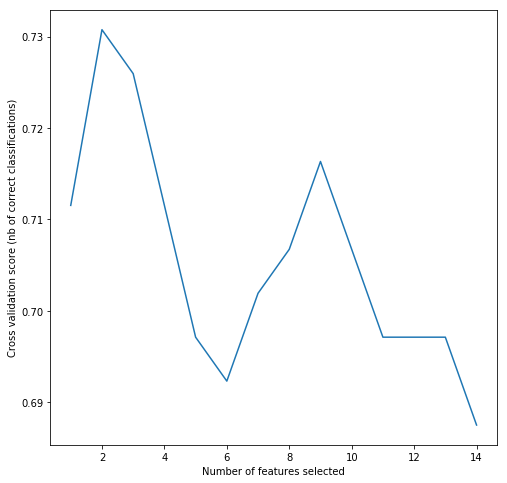

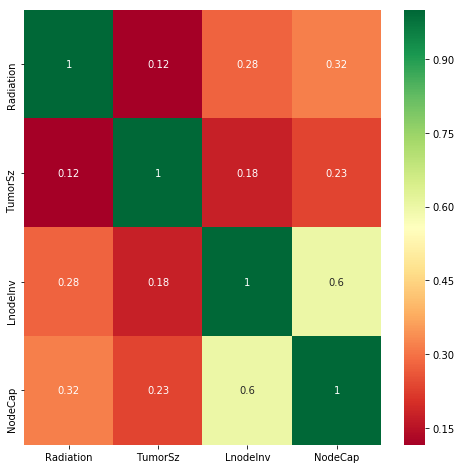

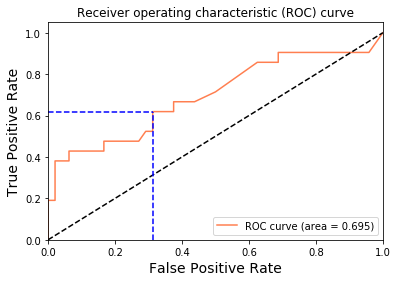

Using a threshold of 0.324 guarantees a sensitivity of 0.619 and a specificity of 0.688, i.e. a false positive rate of 31.25%.
the number of significant features in the model were 5
the features used in the model were
number 5 most significant feature Radiation P value 0.2538618842734654
number 4 most significant feature Malignancy P value 0.5806292808900639
number 3 most significant feature TumorSz P value 0.008323460201116451
number 2 most significant feature LnodeInv P value 0.013222711234413988
number 1 most significant feature NodeCap P value 7.639840151240013e-06
 
the performance of the model on the test data is as follows:
the model gives 8 true positives
the model gives 47 true negatives
the model gives 1 type one errors
the model gives 13 type two errors
the sensitivity of the model is 0.11594202898550725
the specificity of the model is 0.6811594202898551
the type one error rate is 0.014492753623188406
the type one error rate is 0.18840579710144928
LogisticRegression accuracy

In [14]:
# *********************************************create plots*************************************************************

Models = [rfecv,rfe,Chi2_test,all]
Opt_Model = Models[counter]

plt.figure(figsize=(8,8))                                                                                               # Plot number of features VS. cross-validation scores
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Xplot = final_train[Model_headers]

plt.subplots(figsize=(8, 8))
sns.heatmap(Xplot.corr(), annot=True, cmap="RdYlGn")
plt.show()

# ***************************************************plot ROC curce*****************************************************
plt.figure()
plt.plot(false_pos, true_pos, color='coral', label='ROC curve (area = %0.3f)' % auc(false_pos, true_pos))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,false_pos[index]], [true_pos[index],true_pos[index]], 'k--', color='blue')
plt.plot([false_pos[index],false_pos[index]], [0,true_pos[index]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % threshold[index] + "guarantees a sensitivity of %.3f " % true_pos[index] +
      "and a specificity of %.3f" % (1-false_pos[index]) +
      ", i.e. a false positive rate of %.2f%%." % (np.array(false_pos[index])*100))

# ***********calculate all TruePos, TrueNeg, FalsePos, FalseNeg for Test data based on prediction **********************

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(y_prediction)):
        if Ytest_final[i+1]==y_prediction[i]==1:
           TP += 1
        if y_prediction[i]==1 and Ytest_final[i+1]!=y_prediction[i]:
           FP += 1
        if Ytest_final[i+1]==y_prediction[i]==0:
           TN += 1
        if y_prediction[i]==0 and Ytest_final[i+1]!=y_prediction[i]:
           FN += 1

tot_features = (len(Chi2_head))
print("the number of significant features in the model were",tot_features)
print("the features used in the model were")


for i in range(len(Chi2_head)):

    print("number", (tot_features-i), "most significant feature", Chi2_head[i], "P value",
          P_val[i])

print(" ")
print("the performance of the model on the test data is as follows:")
print("the model gives", TP, "true positives")
print("the model gives", TN, "true negatives")
print("the model gives", FP, "type one errors")
print("the model gives", FN, "type two errors")

print("the sensitivity of the model is", TP/(len(y_prediction)))
print("the specificity of the model is", TN/(len(y_prediction)))
print("the type one error rate is", FP/(len(y_prediction)))
print("the type one error rate is", FN/(len(y_prediction)))

print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(Ytest_final, y_prediction))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(Ytest_final, y_prediction_prob))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(false_pos, true_pos))
print("Optimal number of features: %d", tot_features)